## **IMPORT STATEMENTS**

In [10]:
# Add import statements here

import re 
import nltk
import json
import string
import gensim
import logging
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
from sklearn import svm
from nltk import tokenize
from sklearn.svm import SVC
from sklearn import metrics
from nltk.collocations import *
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.feature_extraction.text import CountVectorizer

## **SENTIMENT ANALYSIS OF AT&T**

**Dataset required for our analysis**

**att.csv:** Dataset for Training  
**atest.csv:** Dataset for Testing

In [2]:
# Importing datasets

att_train = pd.read_csv("att.csv")
att_test = pd.read_csv("atest.csv")

att_train.head()
att_test.head()

,Date,Reviewer,Content,Rating,Label
0,12/29/2020,Mary of Dallas,Absolutely the worse customer service I have e...,1,0
1,12/28/2020,kor of Derwood,Don't use AT&T. I switched from T-Mobile to AT...,1,0
2,12/28/2020,Mike of Edison,The worst wireless company ever from the servi...,1,0
3,12/28/2020,Heather of Framingham,We have a family plan with 4 cell phones (iPho...,1,0
4,12/23/2020,Sylvia of Mobile,AT&T is a scam of the highest magnitude. I tur...,1,0


,Date,Reviewer,Content,Rating,Label
0,5/11/2021,Joyce of San Francisco,"Every month, when my phone bill arrives, the c...",1,0
1,5/6/2021,Mohammed of Savannah,"I have ordered home internet, and porting phon...",1,0
2,5/5/2021,David of Plano,I called in asking if I bought a phone if I ca...,1,0
3,5/1/2021,Jonel of Roanoke,AT&T: The worst company in the world. I have b...,1,0
4,4/2/2021,Denis of Slidell,"January 16th, 2021 I entered the AT&T store in...",1,0


**Supervised Sentiment Analysis Using Word Vectors**

In [9]:
# Creating a function to train word vectors

def train_wordvec(docs, vector_size = 100):
    
    wv_model = None
    
    # add your code here
    
    # Tokenize docs into tokens
    sentences=[[token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc.lower()) \
                 if token not in string.punctuation and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in docs]
    
    # logging information
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    
    # Using gensim package to train word vectors
    wv_model = word2vec.Word2Vec(sentences, min_count=5, vector_size=100, window=5, workers=4)
    
    return wv_model

In [10]:
wv_model = train_wordvec(att_train["Content"], vector_size = 100)

2021-06-15 00:42:00,519 : INFO : collecting all words and their counts
2021-06-15 00:42:00,519 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-15 00:42:00,647 : INFO : collected 16643 word types from a corpus of 826569 raw words and 4587 sentences
2021-06-15 00:42:00,648 : INFO : Creating a fresh vocabulary
2021-06-15 00:42:00,671 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4820 unique words (28.96112479721204%% of original 16643, drops 11823)', 'datetime': '2021-06-15T00:42:00.670778', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2021-06-15 00:42:00,671 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 808471 word corpus (97.8104671237368%% of original 826569, drops 18098)', 'datetime': '2021-06-15T00:42:00.671718', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:3

In [11]:
# Creating a function to generate vector representation of documents

def generate_doc_vector(docs, wv_model):
    
    vectors = None
    
    # add your code here
    
    # Tokenize each document doc in docs into tokens
    doc =[[token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc.lower()) \
                 if token not in string.punctuation and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in docs]

    # looking for word vector in wv_model for each token in doc
    wv_in_model = [[wv_model.wv[token] for token in lists if token in wv_model.wv.key_to_index]for lists in doc]
    
    # Certain vectors were empty hence added np.zeros(100) to avoid error
    # Calculating document vector (d) mean of word vector of its token
    d = []
    
    for w_vec in wv_in_model:
        if w_vec == []:
            d.append(np.zeros(100))
        else:
            d.append(np.vstack(w_vec).mean(axis=0))
    
    # Vector representation
    vectors = np.array(d)
    
    print(vectors.shape)
    return vectors

In [12]:
train_X = generate_doc_vector(att_train["Content"], wv_model)
test_X = generate_doc_vector(att_test["Content"], wv_model)

(4587, 100)
(38, 100)


**METHOD 1: SUPPORT VECTOR MACHINE**

**Algorithm and Performance Evaluation**

In [25]:
# Creating a function to predict sentiments using support vector machine algorithm
# Evaluating performance

def predict_sentiment(train_text, train_label, test_text, test_label, vector_size = 100):
    
    # add your code here
    
    # Calling train_wordvec to train a word vector
    train_wordvec(train_text, 100)
    
    # Calling generate_doc_vector to generate vector representations
    train_X = generate_doc_vector(train_text,wv_model)
    
    # Calling generate_doc_vector to generate vector representations
    test_X = generate_doc_vector(test_text,wv_model)
    
    # Initiate a linear SVM model
    clf = svm.LinearSVC(max_iter=5000)
    
    # Train a SVM model
    clf.fit(train_X, train_label)
    
    # Predict for the test dataset
    predicted=clf.predict(test_X)
    
    # Create a dataframe with sentiment and ground truth label
    confusion_df = pd.DataFrame(list(zip(test_label.values, predicted)), columns = ["label", "sentiment"])
    confusion_df.head()

    # generate crosstab between sentiment and true labels
    att_ctab = pd.crosstab(index=confusion_df.sentiment, columns=confusion_df.label)
    print(att_ctab)
    
    # Calculate performance metrics
    print(classification_report(test_label, predicted))
    
    return None

In [26]:
predict_sentiment(att_train["Content"], att_train["Label"],\
                  att_test["Content"], att_test["Label"],\
                  vector_size = 100)

2021-06-15 03:46:19,919 : INFO : collecting all words and their counts
2021-06-15 03:46:19,921 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-15 03:46:20,050 : INFO : collected 16643 word types from a corpus of 826569 raw words and 4587 sentences
2021-06-15 03:46:20,051 : INFO : Creating a fresh vocabulary
2021-06-15 03:46:20,073 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4820 unique words (28.96112479721204%% of original 16643, drops 11823)', 'datetime': '2021-06-15T03:46:20.073753', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2021-06-15 03:46:20,074 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 808471 word corpus (97.8104671237368%% of original 826569, drops 18098)', 'datetime': '2021-06-15T03:46:20.074761', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:3

(4587, 100)
(38, 100)
label       0
sentiment    
0          38
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



**Performance Evaluation - Support Vector Machine (AT&T)**

*The performance evaluation result generated through Support Vector Machine Model shows that the f1-score and weighted average for AT&T is 1.00. This means that the sentiment predicted for all the testing dataset is correct.*

**Confusion Matrix - Support Vector Machine (AT&T)**

*The testing dataset consisted of 38 negative reviews. Through Support Vector Machine method, all the reviews were predicted correctly.*

**METHOD 2: NAIVE BAYES**

**Algorithm and Performance Evaluation**

In [27]:
# Creating a function to predict sentiments using support vector machine algorithm
# Evaluating performance

def predict_sentiment(train_text, train_label, test_text, test_label, vector_size = 100):
    
    # add your code here
    
    # Calling train_wordvec to train a word vector
    train_wordvec(train_text, 100)
    
    # Calling generate_doc_vector to generate vector representations
    train_X = generate_doc_vector(train_text,wv_model)
    
    # Calling generate_doc_vector to generate vector representations
    test_X = generate_doc_vector(test_text,wv_model)
    
    # Initiate a MinMaxScaler
    scaler = MinMaxScaler()
    
    # Fit and Transform the training data into MinMaxScaler
    train_x = scaler.fit_transform(train_X)
    
    # Fit and Transform the testing data into MinMaxScaler
    test_x = scaler.fit_transform(test_X)
    
    # Initiate a MultinomialNB model
    # Train a multinomial naive Bayes model using the testing data
    clf = MultinomialNB().fit(train_x, train_label)
    
    # Predict for the test dataset
    predicted=clf.predict(test_x)
    
    # Create a dataframe with sentiment and ground truth label
    confusion_df = pd.DataFrame(list(zip(test_label.values, predicted)), columns = ["label", "sentiment"])
    confusion_df.head()

    # generate crosstab between sentiment and true labels
    att_ctab = pd.crosstab(index=confusion_df.sentiment, columns=confusion_df.label)
    print(att_ctab)   
    
    # Calculate performance metrics
    print(classification_report(test_label, predicted))
    
    return None

In [28]:
predict_sentiment(att_train["Content"], att_train["Label"],\
                  att_test["Content"], att_test["Label"],\
                  vector_size = 100)

2021-06-15 03:47:31,975 : INFO : collecting all words and their counts
2021-06-15 03:47:31,976 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-15 03:47:32,093 : INFO : collected 16643 word types from a corpus of 826569 raw words and 4587 sentences
2021-06-15 03:47:32,094 : INFO : Creating a fresh vocabulary
2021-06-15 03:47:32,116 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4820 unique words (28.96112479721204%% of original 16643, drops 11823)', 'datetime': '2021-06-15T03:47:32.116174', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2021-06-15 03:47:32,117 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 808471 word corpus (97.8104671237368%% of original 826569, drops 18098)', 'datetime': '2021-06-15T03:47:32.117172', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:3

(4587, 100)
(38, 100)
label       0
sentiment    
0          33
1           5
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        38
           1       0.00      0.00      0.00         0

    accuracy                           0.87        38
   macro avg       0.50      0.43      0.46        38
weighted avg       1.00      0.87      0.93        38



C:\Users\ankit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ankit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ankit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**PERFORMANCE EVALUATION**

**Performance Evaluation - Naive Bayes (AT&T)**

*The performance evaluation result generated through Naive Bayes Model shows that the f1-score and weighted average for AT&T is 0.91.*

**Confusion Matrix - Naive Bayes (AT&T)**

*The testing dataset consisted of 38 negative reviews. Through Naive Bayes method, 33 reviews were predicted correctly and 5 reviews were predicted incorrectly.*

**MODEL COMPARISON**

**Comparing Support Vector Machine and Naive Bayes Method**

In [14]:
f1_Score_Weighted_Average = [1.00, 0.93]

In [15]:
Method = ['Support Vector Machine', 'Naive Bayes']

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Method and thier respective f1-score for AT&T')

Text(0.5, 0, 'Method')

Text(0, 0.5, 'f1-score')

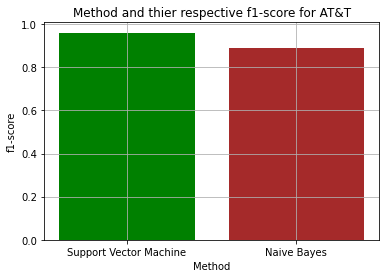

In [18]:
New_Colors = ['green', 'brown']
plt.bar(Method, f1_Score_Weighted_Average, color=New_Colors)
plt.title('Method and thier respective f1-score for AT&T')
plt.xlabel('Method')
plt.ylabel('f1-score')
plt.grid(True)
plt.show()

*Support Vector Machine model performs better than Naive Bayes model. The weighted average f1-score by Support Vector Machine method is 1.0 and through Naive Bayes method is 0.93.*

## **SENTIMENT ANALYSIS OF VERIZON**

**Dataset required for our analysis**

**verizon.csv:** Dataset for Training  
**vtest.csv:** Dataset for Testing

In [11]:
# Importing Datasets

verizon_train = pd.read_csv("verizon.csv")
verizon_test = pd.read_csv("vtest.csv")

verizon_train.head()
verizon_test.head()

,Date,Reviewer,Content,Rating,Label
0,11/3/2020,Sonia of Lynn,This morning I had the pleasure of speaking wi...,5,1
1,9/3/2020,Amy of Jacksonville,I Live in Florida and was visiting in Georgia....,5,1
2,8/12/2020,Judy of Asheville,My husband and I were surprisingly pleased wit...,5,1
3,8/12/2020,Sarah of Lawndale,hours on the phone with Verizon and Asurion. B...,5,1
4,11/29/2020,Jody of Bentonville,Resolution response: Verizon finally came thr...,0,0


,Date,Reviewer,Content,Rating,Label
0,2/13/2021,Misty of Saint Augustine,I called into Verizon today literally in tears...,5,1
1,5/17/2021,John of Tulsa,"I am a previous customer, I had Verizon for ab...",2,0
2,5/15/2021,Charles of Clarks Summit,I have been a Verizon Wireless customer for al...,1,0
3,5/14/2021,Michele of Arlington,I was a loyal Verizon customer but my recent i...,1,0
4,5/13/2021,Mary of Erie,Because the Verizon store told me directions t...,1,0


**Supervised Sentiment Analysis Using Word Vectors**

In [17]:
# Creating a function to train word vectors

def train_wordvec(docs, vector_size = 100):
    
    wv_model = None
    
    # add your code here
    
    # Tokenize docs into tokens
    sentences=[[token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc.lower()) \
                 if token not in string.punctuation and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in docs]
    
    # logging information
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    
    # Using gensim package to train word vectors
    wv_model = word2vec.Word2Vec(sentences, min_count=5, vector_size=100, window=5, workers=4)
    
    return wv_model

In [18]:
wv_model = train_wordvec(verizon_train["Content"], vector_size = 100)

2021-06-15 00:43:45,340 : INFO : collecting all words and their counts
2021-06-15 00:43:45,341 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-15 00:43:45,428 : INFO : collected 16401 word types from a corpus of 752830 raw words and 4445 sentences
2021-06-15 00:43:45,428 : INFO : Creating a fresh vocabulary
2021-06-15 00:43:45,464 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4741 unique words (28.90677397719651%% of original 16401, drops 11660)', 'datetime': '2021-06-15T00:43:45.464976', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2021-06-15 00:43:45,465 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 734856 word corpus (97.61247559209914%% of original 752830, drops 17974)', 'datetime': '2021-06-15T00:43:45.465974', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:

In [19]:
# Creating a function to generate vector representation of documents

def generate_doc_vector(docs, wv_model):
    
    vectors = None
    
    # add your code here
    
    # Tokenize each document doc in docs into tokens
    doc =[[token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc.lower()) \
                 if token not in string.punctuation and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in docs]

    # looking for word vector in wv_model for each token in doc
    wv_in_model = [[wv_model.wv[token] for token in lists if token in wv_model.wv.key_to_index]for lists in doc]
    
    # Certain vectors were empty hence added np.zeros(100) to avoid error
    # Calculating document vector (d) mean of word vector of its token
    d = []
    
    for w_vec in wv_in_model:
        if w_vec == []:
            d.append(np.zeros(100))
        else:
            d.append(np.vstack(w_vec).mean(axis=0))
    
    # Vector representation
    vectors = np.array(d)
    
    print(vectors.shape)
    return vectors

In [20]:
train_X = generate_doc_vector(verizon_train["Content"], wv_model)
test_X = generate_doc_vector(verizon_test["Content"], wv_model)

(4445, 100)
(103, 100)


**METHOD 1: SUPPORT VECTOR MACHINE**

**Algorithm and Performance Evaluation**

In [29]:
# Creating a function to predict sentiments using support vector machine algorithm
# Evaluating performance

def predict_sentiment(train_text, train_label, test_text, test_label, vector_size = 100):
    
    # add your code here
    
    # Calling train_wordvec to train a word vector
    train_wordvec(train_text, 100)
    
    # Calling generate_doc_vector to generate vector representations
    train_X = generate_doc_vector(train_text,wv_model)
    
    # Calling generate_doc_vector to generate vector representations
    test_X = generate_doc_vector(test_text,wv_model)
    
    # Initiate a linear SVM model
    clf = svm.LinearSVC(max_iter=5000)
    
    # Train a SVM model
    clf.fit(train_X, train_label)
    
    # Predict for the test dataset
    predicted=clf.predict(test_X)
    
    # Create a dataframe with sentiment and ground truth label
    confusion_df = pd.DataFrame(list(zip(test_label.values, predicted)), columns = ["label", "sentiment"])
    confusion_df.head()

    # generate crosstab between sentiment and true labels
    att_ctab = pd.crosstab(index=confusion_df.sentiment, columns=confusion_df.label)
    print(att_ctab)    
    
    # Calculate performance metrics
    print(classification_report(test_label, predicted))
    
    return None

In [30]:
predict_sentiment(verizon_train["Content"], verizon_train["Label"],\
                  verizon_test["Content"], verizon_test["Label"],\
                  vector_size = 100)

2021-06-15 03:48:20,714 : INFO : collecting all words and their counts
2021-06-15 03:48:20,715 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-15 03:48:20,826 : INFO : collected 16401 word types from a corpus of 752830 raw words and 4445 sentences
2021-06-15 03:48:20,827 : INFO : Creating a fresh vocabulary
2021-06-15 03:48:20,848 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4741 unique words (28.90677397719651%% of original 16401, drops 11660)', 'datetime': '2021-06-15T03:48:20.848501', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2021-06-15 03:48:20,849 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 734856 word corpus (97.61247559209914%% of original 752830, drops 17974)', 'datetime': '2021-06-15T03:48:20.849499', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:

(4445, 100)
(103, 100)
label       0  1
sentiment       
0          98  2
1           3  0
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       101
           1       0.00      0.00      0.00         2

    accuracy                           0.95       103
   macro avg       0.49      0.49      0.49       103
weighted avg       0.96      0.95      0.96       103



**Performance Evaluation - Support Vector Machine (Verizon)**

*The performance evaluation result generated through Support Vector Machine Model shows that the f1-score for Verizon is 0.98 and weighted average for Verizon is 0.96.*

**Confusion Matrix - Support Vector Machine (Verizon)**

*The testing dataset consisted of 101 negative reviews and 2 positive reviews. Through Support Vector Machine method, 98 reviews were correctly predicted as negative and none of the reviews were correctly predicted as positive.*

**METHOD 2: NAIVE BAYES**

**Algorithm and Performance Evaluation**

In [31]:
# Creating a function to predict sentiments using support vector machine algorithm
# Evaluating performance

def predict_sentiment(train_text, train_label, test_text, test_label, vector_size = 100):
    
    # add your code here
    
    # Calling train_wordvec to train a word vector
    train_wordvec(train_text, 100)
    
    # Calling generate_doc_vector to generate vector representations
    train_X = generate_doc_vector(train_text,wv_model)
    
    # Calling generate_doc_vector to generate vector representations
    test_X = generate_doc_vector(test_text,wv_model)
    
    # Initiate a MinMaxScaler
    scaler = MinMaxScaler()
    
    # Fit and Transform the training data into MinMaxScaler
    train_x = scaler.fit_transform(train_X)
    
    # Fit and Transform the testing data into MinMaxScaler
    test_x = scaler.fit_transform(test_X)
    
    # Initiate a MultinomialNB model
    # Train a multinomial naive Bayes model using the testing data
    clf = MultinomialNB().fit(train_x, train_label)
    
    # Predict for the test dataset
    predicted=clf.predict(test_x)
    
    # Create a dataframe with sentiment and ground truth label
    confusion_df = pd.DataFrame(list(zip(test_label.values, predicted)), columns = ["label", "sentiment"])
    confusion_df.head()

    # generate crosstab between sentiment and true labels
    att_ctab = pd.crosstab(index=confusion_df.sentiment, columns=confusion_df.label)
    print(att_ctab)
    
    # Calculate performance metrics
    print(classification_report(test_label, predicted))
    
    return None

In [32]:
predict_sentiment(verizon_train["Content"], verizon_train["Label"],\
                  verizon_test["Content"], verizon_test["Label"],\
                  vector_size = 100)

2021-06-15 03:48:38,691 : INFO : collecting all words and their counts
2021-06-15 03:48:38,691 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-06-15 03:48:38,804 : INFO : collected 16401 word types from a corpus of 752830 raw words and 4445 sentences
2021-06-15 03:48:38,805 : INFO : Creating a fresh vocabulary
2021-06-15 03:48:38,827 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 4741 unique words (28.90677397719651%% of original 16401, drops 11660)', 'datetime': '2021-06-15T03:48:38.827146', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2021-06-15 03:48:38,828 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 734856 word corpus (97.61247559209914%% of original 752830, drops 17974)', 'datetime': '2021-06-15T03:48:38.828097', 'gensim': '4.0.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:

(4445, 100)
(103, 100)
label       0  1
sentiment       
0          85  2
1          16  0
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       101
           1       0.00      0.00      0.00         2

    accuracy                           0.83       103
   macro avg       0.49      0.42      0.45       103
weighted avg       0.96      0.83      0.89       103



**PERFORMANCE EVALUATION**

**Performance Evaluation - Naive Bayes (Verizon)**

*The performance evaluation result generated through Naive Bayes Model shows that the f1-score for Verizon is 0.90 and weighted average for Verizon is 0.89.*

**Confusion Matrix - Naive Bayes (Verizon)**

*The testing dataset consisted of 101 negative reviews and 2 positive reviews. Through Naive Bayes method, 85 reviews were predicted correctly as negative and none of the reviews were correctly predicted as positive.*

**MODEL COMPARSION**

**Comparing Support Vector Machine and Naive Bayes Method**

In [19]:
f1_Score_Weighted_Average = [0.96, 0.89]

In [20]:
Method = ['Support Vector Machine', 'Naive Bayes']

<BarContainer object of 2 artists>

Text(0.5, 1.0, 'Method and thier respective f1-score for Verizon')

Text(0.5, 0, 'Method')

Text(0, 0.5, 'f1-score')

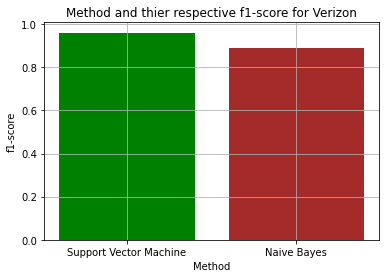

In [21]:
New_Colors = ['green', 'brown']
plt.bar(Method, f1_Score_Weighted_Average, color=New_Colors)
plt.title('Method and thier respective f1-score for Verizon')
plt.xlabel('Method')
plt.ylabel('f1-score')
plt.grid(True)
plt.show()

*Support Vector Machine model performs better than Naive Bayes model. The weighted average f1-score by Support Vector Machine method is 0.96 and through Naive Bayes method is 0.89.*

## **ANALYSIS**

**AT&T**

**Year 2015 to 2020**

In [8]:
# counting the number of positive and negative reviews

att_train.Label.value_counts()

0    4196
1     391
Name: Label, dtype: int64

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='Label', ylabel='count'>

Text(0.5, 1.0, 'Total Review Numbers for Each Label')

Text(0.5, 0, 'Label')

Text(0, 0.5, 'Count of Label')

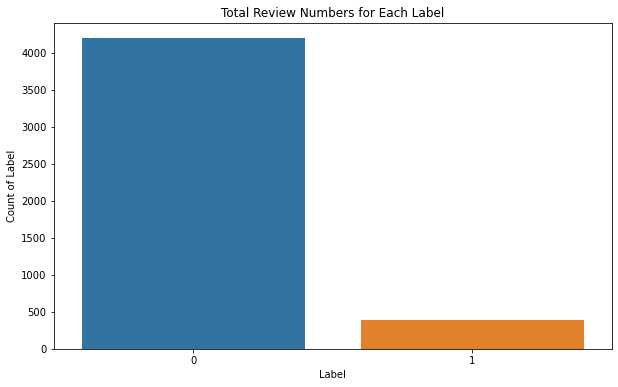

0    4196
1     391
Name: Label, dtype: int64

In [14]:
# bifurcation of labels

plt.figure(figsize = (10,6))
sns.countplot(data = att_train, x = 'Label')
plt.title('Total Review Numbers for Each Label', color='black')
plt.xlabel('Label')
plt.ylabel('Count of Label')
plt.show()

# Customer totals for each rating class
att_train['Label'].value_counts()

*From 2015 to 2020, AT&T received 4196 negative reviews and 391 positive reviews*

<Figure size 720x432 with 0 Axes>

Label
0    4196
1     391
Name: Label, dtype: int64

<AxesSubplot:ylabel='Label'>

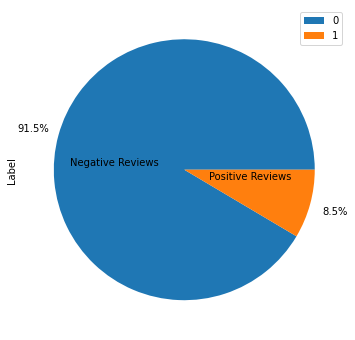

In [26]:
# bifuraction of label as percentage

plt.figure(figsize = (10,6))
att_train.groupby('Label').Label.count()
att_train.groupby('Label').Label.count().plot(kind='pie',autopct='%1.1f%%', pctdistance=1.2, labeldistance=0.2, labels=['Negative Reviews','Positive Reviews'])
plt.legend(loc=1, labels=att_train.index)
plt.show()

*The percentage of negative reviews recieved by AT&T is 91.5% and positive reviews is 8.5% over a span of six years*

In [39]:
# since date is in object type, we shall convert it into datetime stamp

att_train['Date'] = pd.to_datetime(att_train['Date'], errors = 'coerce')

In [40]:
# checking the count of type of reviews on a yearly basis

year_label_train = pd.DataFrame(att_train.groupby([att_train.Date.dt.year]).Label.value_counts())
year_label_train

Label
Date Label       
2015 0       1058
     1         12
2016 0        763
     1         31
2017 0        793
     1        196
2018 0        713
     1         74
2019 0        620
     1         17
2020 0        249
     1         61

*From the above table, we can analyse the number of positive and negative reviews received by AT&T in each year.*  
*In **2015**, AT&T got 1058 negative reviews and 12 positove reviews*  
*In **2016**, AT&T got 763 negative reviews and 31 positive reviews*  
*In **2017**, AT&T got 793 negative reviews and 196 positive reviews*  
*In **2018**, AT&T got 713 negative reviews and 74 positive reviews*  
*In **2019**, AT&T got 620 negative reviews and 17 positive reviews*  
*In **2020**, AT&T got 249 negative reviews and 61 positive reviews*  
*In **2015** it received highest number of negative reviews and in **2020** it received lowest number of negative reviews*  
*In **2017** it received highest number of positive reviews and in **2015** it received lowest number of positive reviews*

**Year 2021**

In [28]:
# counting the number of positive and negative reviews

att_test.Label.value_counts()

0    38
Name: Label, dtype: int64

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='Label', ylabel='count'>

Text(0.5, 1.0, 'Total Review Numbers for Each Label')

Text(0.5, 0, 'Label')

Text(0, 0.5, 'Count of Label')

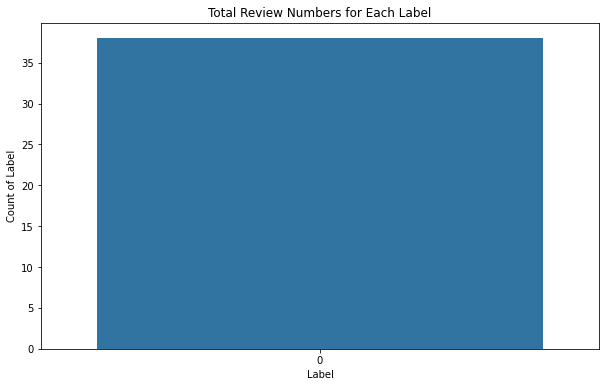

0    38
Name: Label, dtype: int64

In [29]:
# bifurcation of labels

plt.figure(figsize = (10,6))
sns.countplot(data = att_test, x = 'Label')
plt.title('Total Review Numbers for Each Label', color='black')
plt.xlabel('Label')
plt.ylabel('Count of Label')
plt.show()

# Customer totals for each rating class
att_test['Label'].value_counts()

*In 2021, AT&T received 38 negative reviews and 0 positive reviews*

<Figure size 720x432 with 0 Axes>

Label
0    38
Name: Label, dtype: int64

<AxesSubplot:ylabel='Label'>

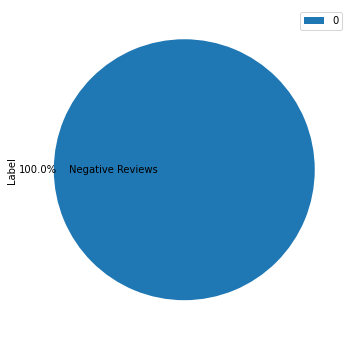

In [38]:
# bifuraction of label as percentage

plt.figure(figsize = (10,6))
att_test.groupby('Label').Label.count()
att_test.groupby('Label').Label.count().plot(kind='pie',autopct='%1.1f%%', pctdistance=1.12, labeldistance=0.2, labels=['Negative Reviews','Positive Reviews'])
plt.legend(loc=1, labels=att_test.index)
plt.show()

*The percentage of negative reviews recieved by AT&T is 100% in the year 2021*

In [42]:
# since date is in object type, we shall convert it into datetime stamp

att_test['Date'] = pd.to_datetime(att_test['Date'], errors = 'coerce')

In [41]:
# checking the count of type of reviews on a yearly basis

year_label_test = pd.DataFrame(att_test.groupby([att_test.Date.dt.year]).Label.value_counts())
year_label_test

,,Label
Date,Label,
2021,0,38


*From the above table, we can analyse the number of positive and negative reviews received by AT&T in each year.*  
*In **2021**, AT&T got 38 negative reviews and 0 positive reviews*  

**VERIZON**

**Year 2015 to 2020**

In [12]:
# counting the number of positive and negative reviews

verizon_train.Label.value_counts()

0    3489
1     956
Name: Label, dtype: int64

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='Label', ylabel='count'>

Text(0.5, 1.0, 'Total Review Numbers for Each Label')

Text(0.5, 0, 'Label')

Text(0, 0.5, 'Count of Label')

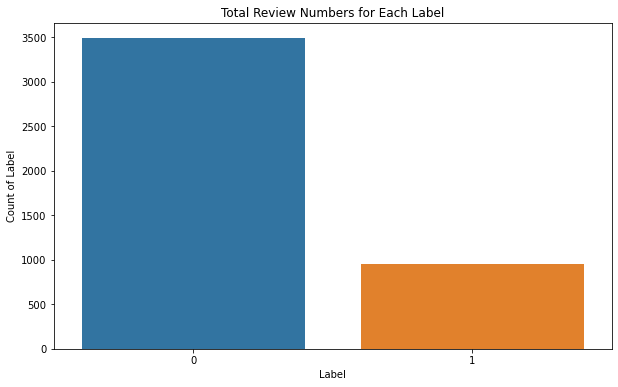

0    3489
1     956
Name: Label, dtype: int64

In [15]:
# bifurcation of labels

plt.figure(figsize = (10,6))
sns.countplot(data = verizon_train, x = 'Label')
plt.title('Total Review Numbers for Each Label', color='black')
plt.xlabel('Label')
plt.ylabel('Count of Label')
plt.show()

# Customer totals for each rating class
verizon_train['Label'].value_counts()

*From 2015 to 2020, Verizon received 3489 negative reviews and 956 positive reviews*

<Figure size 720x432 with 0 Axes>

Label
0    3489
1     956
Name: Label, dtype: int64

<AxesSubplot:ylabel='Label'>

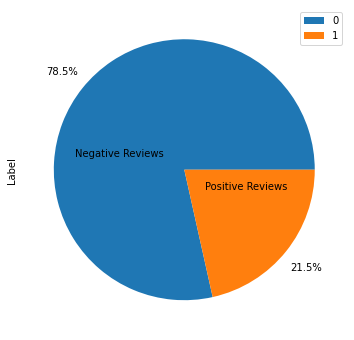

In [27]:
# bifuraction of label as percentage

plt.figure(figsize = (10,6))
verizon_train.groupby('Label').Label.count()
verizon_train.groupby('Label').Label.count().plot(kind='pie',autopct='%1.1f%%', pctdistance=1.2, labeldistance=0.2, labels=['Negative Reviews','Positive Reviews'])
plt.legend(loc=1, labels=verizon_train.index)
plt.show()

*The percentage of negative reviews recieved by Verizon is 78.5% and positive reviews is 21.5% over a span of six years*

In [43]:
# since date is in object type, we shall convert it into datetime stamp

verizon_train['Date'] = pd.to_datetime(verizon_train['Date'], errors = 'coerce')

In [44]:
# checking the count of type of reviews on a yearly basis

year_label_train = pd.DataFrame(verizon_train.groupby([verizon_train.Date.dt.year]).Label.value_counts())
year_label_train

Label
Date Label       
2015 0        880
     1         20
2016 0        580
     1         41
2017 0        627
     1        492
2018 0        504
     1        213
2019 0        492
     1         45
2020 0        406
     1        145

*From the above table, we can analyse the number of positive and negative reviews received by Verizon in each year.*  
*In **2015**, Verizon got 880 negative reviews and 20 positove reviews*  
*In **2016**, Verizon got 580 negative reviews and 41 positive reviews*  
*In **2017**, Verizon got 627 negative reviews and 492 positive reviews*  
*In **2018**, Verizon got 504 negative reviews and 213 positive reviews*  
*In **2019**, Verizon got 492 negative reviews and 45 positive reviews*  
*In **2020**, Verizon got 406 negative reviews and 145 positive reviews*  
*In **2015** it received highest number of negative reviews and in **2016** it received lowest number of negative reviews*  
*In **2017** it received highest number of positive reviews and in **2015** it received lowest number of positive reviews*

**Year 2021**

In [47]:
# counting the number of positive and negative reviews

verizon_test.Label.value_counts()

0    101
1      2
Name: Label, dtype: int64

<Figure size 720x432 with 0 Axes>

<AxesSubplot:xlabel='Label', ylabel='count'>

Text(0.5, 1.0, 'Total Review Numbers for Each Label')

Text(0.5, 0, 'Label')

Text(0, 0.5, 'Count of Label')

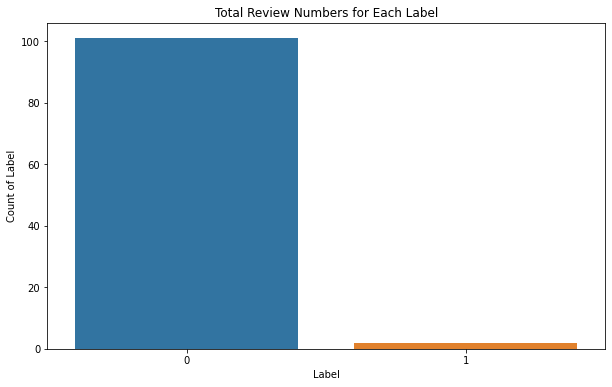

0    101
1      2
Name: Label, dtype: int64

In [48]:
# bifurcation of labels

plt.figure(figsize = (10,6))
sns.countplot(data = verizon_test, x = 'Label')
plt.title('Total Review Numbers for Each Label', color='black')
plt.xlabel('Label')
plt.ylabel('Count of Label')
plt.show()

# Customer totals for each rating class
verizon_test['Label'].value_counts()

*In 2021, Verizon received 101 negative reviews and 2 positive reviews*

<Figure size 720x432 with 0 Axes>

Label
0    101
1      2
Name: Label, dtype: int64

<AxesSubplot:ylabel='Label'>

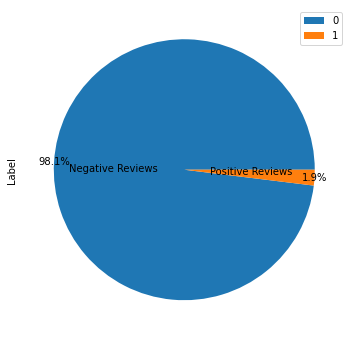

In [55]:
# bifuraction of label as percentage

plt.figure(figsize = (10,6))
verizon_test.groupby('Label').Label.count()
verizon_test.groupby('Label').Label.count().plot(kind='pie',autopct='%1.1f%%', pctdistance=1.0, labeldistance=0.2, labels=['Negative Reviews','Positive Reviews'])
plt.legend(loc=1, labels=verizon_test.index)
plt.show()

*The percentage of negative reviews recieved by Verizon is 98.1% and positive reviews is 1.9% in the year 2021*

In [45]:
# since date is in object type, we shall convert it into datetime stamp

verizon_test['Date'] = pd.to_datetime(verizon_test['Date'], errors = 'coerce')

In [46]:
# checking the count of type of reviews on a yearly basis

year_label_test = pd.DataFrame(verizon_test.groupby([verizon_test.Date.dt.year]).Label.value_counts())
year_label_test

Label
Date Label       
2021 0        101
     1          2

*From the above table, we can analyse the number of positive and negative reviews received by Verizon in each year.*  
*In **2021**, Verizon got 101 negative reviews and 2 positive reviews*